# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

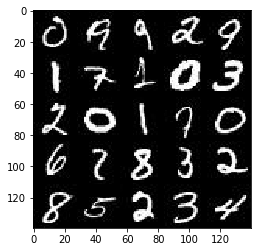

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

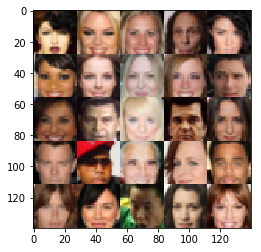

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 28x28xout_channel_dim now    
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate: 0.001})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate: 0.001})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5235... Generator Loss: 20.3006
Epoch 1/2... Discriminator Loss: 0.1477... Generator Loss: 2.6332
Epoch 1/2... Discriminator Loss: 2.2114... Generator Loss: 0.3773
Epoch 1/2... Discriminator Loss: 0.2429... Generator Loss: 2.0351
Epoch 1/2... Discriminator Loss: 0.4442... Generator Loss: 2.6106
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 1.6541... Generator Loss: 1.9915
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 1.6159
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 1.7456


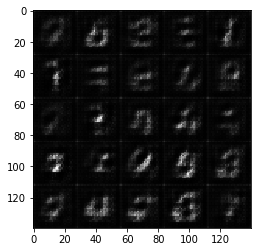

Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 1.4424
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 1.7090
Epoch 1/2... Discriminator Loss: 1.4878... Generator Loss: 1.6103
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 1.6328... Generator Loss: 0.2847
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.4891
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 0.2195
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.3866
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.3375


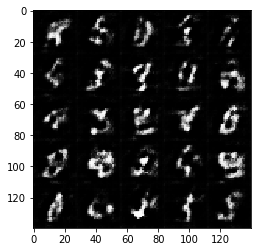

Epoch 1/2... Discriminator Loss: 1.6783... Generator Loss: 0.2645
Epoch 1/2... Discriminator Loss: 1.6309... Generator Loss: 0.3056
Epoch 1/2... Discriminator Loss: 1.5654... Generator Loss: 0.3635
Epoch 1/2... Discriminator Loss: 1.4984... Generator Loss: 0.3041
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.5716... Generator Loss: 1.1550
Epoch 1/2... Discriminator Loss: 1.6465... Generator Loss: 1.3781
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 1.1900


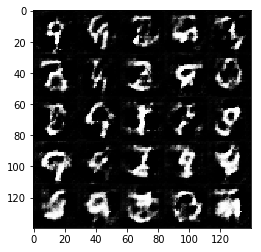

Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 1.4228
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 1.1073
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 1.1234
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.6992... Generator Loss: 0.2504
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 1.7641... Generator Loss: 0.2556
Epoch 1/2... Discriminator Loss: 1.6401... Generator Loss: 0.2719
Epoch 1/2... Discriminator Loss: 1.6444... Generator Loss: 0.3125
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.3225


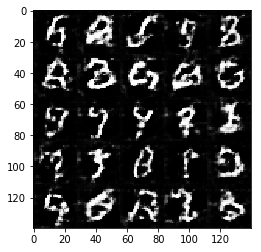

Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.3709
Epoch 1/2... Discriminator Loss: 1.6868... Generator Loss: 0.2942
Epoch 1/2... Discriminator Loss: 1.6728... Generator Loss: 0.2724
Epoch 1/2... Discriminator Loss: 1.7358... Generator Loss: 0.2657
Epoch 1/2... Discriminator Loss: 1.5838... Generator Loss: 0.3146
Epoch 1/2... Discriminator Loss: 1.5591... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 1.7893... Generator Loss: 0.2204
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 1.4760
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.5909


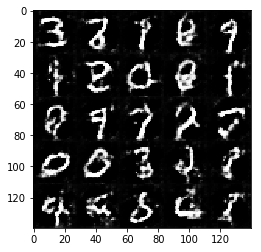

Epoch 1/2... Discriminator Loss: 1.5993... Generator Loss: 0.3135
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 0.4218
Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 0.2797
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.4043
Epoch 1/2... Discriminator Loss: 1.6424... Generator Loss: 0.2758
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 1.5581... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 1.5842... Generator Loss: 0.3155
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 0.3580


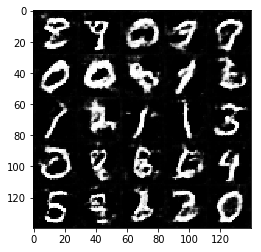

Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.4062
Epoch 1/2... Discriminator Loss: 1.8122... Generator Loss: 0.2182
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.3611
Epoch 1/2... Discriminator Loss: 1.7509... Generator Loss: 0.2432
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 1.1231
Epoch 1/2... Discriminator Loss: 1.5936... Generator Loss: 0.2940
Epoch 1/2... Discriminator Loss: 1.6670... Generator Loss: 0.2774


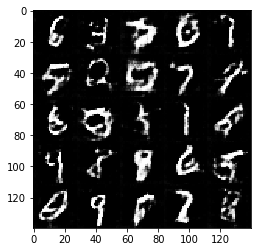

Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 1.7500... Generator Loss: 0.2439
Epoch 1/2... Discriminator Loss: 1.4965... Generator Loss: 0.3508
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 1.7717
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 1.3771
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 1.0221
Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.7240... Generator Loss: 1.7093
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 0.7417
Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 0.3204


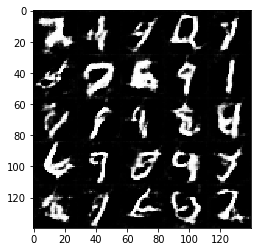

Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 1.6735
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 1.5257
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 1.9439... Generator Loss: 0.1919
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.6278... Generator Loss: 0.2596
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.3591


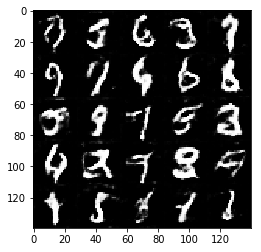

Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 1.8753
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 1.3439
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 1.2980
Epoch 1/2... Discriminator Loss: 0.9872... Generator Loss: 1.0149
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.6805
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 1.3807
Epoch 1/2... Discriminator Loss: 1.6985... Generator Loss: 1.9364


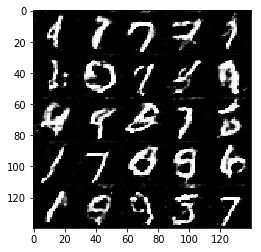

Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 1.4186
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 1.2670
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 2.0482
Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 1.2508
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 2.0831
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 1.4822


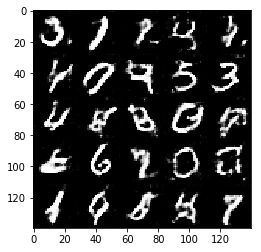

Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.3522
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.4099
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 1.9499
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 2.0034
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.8792... Generator Loss: 0.1982
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.3783
Epoch 1/2... Discriminator Loss: 1.9555... Generator Loss: 0.2035
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.4181


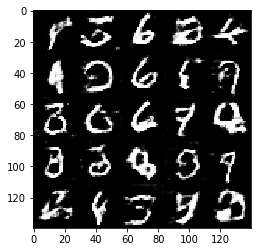

Epoch 1/2... Discriminator Loss: 1.6233... Generator Loss: 0.3037
Epoch 1/2... Discriminator Loss: 2.0215... Generator Loss: 0.1813
Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.3620
Epoch 1/2... Discriminator Loss: 2.1297... Generator Loss: 0.1647
Epoch 1/2... Discriminator Loss: 2.6017... Generator Loss: 0.1114
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 1.7074... Generator Loss: 0.2924
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.3464
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.1538


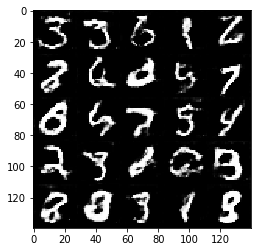

Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.3462
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 2.1184... Generator Loss: 0.1718
Epoch 1/2... Discriminator Loss: 1.9566... Generator Loss: 0.2116
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.3508
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 0.5499
Epoch 1/2... Discriminator Loss: 1.9066... Generator Loss: 0.1972
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.1585
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 0.8528
Epoch 1/2... Discriminator Loss: 1.8381... Generator Loss: 0.2542


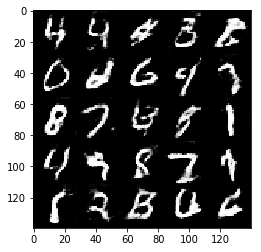

Epoch 1/2... Discriminator Loss: 0.8885... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 0.7291... Generator Loss: 1.2974
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.4460
Epoch 1/2... Discriminator Loss: 2.0244... Generator Loss: 0.1844
Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 1.9386... Generator Loss: 0.2211
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 1.9258
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.5509


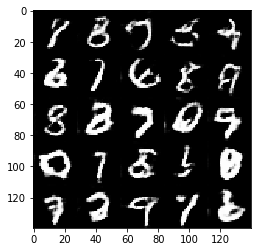

Epoch 1/2... Discriminator Loss: 0.9072... Generator Loss: 2.0621
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 1.1699
Epoch 1/2... Discriminator Loss: 1.5718... Generator Loss: 0.3490
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.4238
Epoch 1/2... Discriminator Loss: 0.9745... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 2.2643
Epoch 1/2... Discriminator Loss: 0.8743... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.8001... Generator Loss: 0.2295
Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.3770


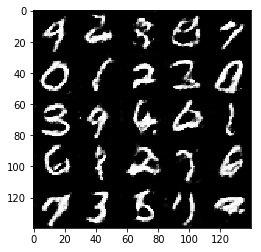

Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.4849
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 2.4555
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 2.3196
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 3.2949
Epoch 1/2... Discriminator Loss: 0.7116... Generator Loss: 1.5461
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.4069
Epoch 1/2... Discriminator Loss: 0.5924... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 1.5959


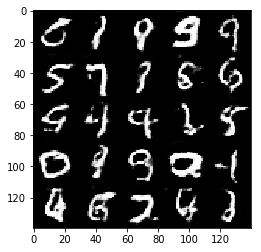

Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 1.7813
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 2.3175
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.3906
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 0.8303
Epoch 1/2... Discriminator Loss: 2.2665... Generator Loss: 0.1346
Epoch 1/2... Discriminator Loss: 1.6959... Generator Loss: 0.2526
Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 0.4308... Generator Loss: 1.7847
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 2.6841


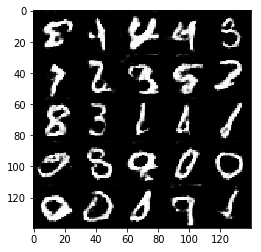

Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 1.6751
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.3373
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.9185
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.3845
Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 1.9297
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.9284
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.4266


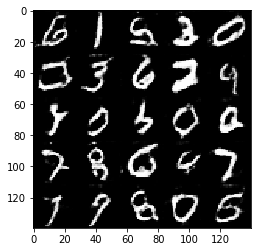

Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 2.1905
Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 1.2214
Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.5124
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.4557
Epoch 2/2... Discriminator Loss: 1.9706... Generator Loss: 0.2206
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 2.2397
Epoch 2/2... Discriminator Loss: 0.7223... Generator Loss: 2.2625
Epoch 2/2... Discriminator Loss: 0.5714... Generator Loss: 1.2159


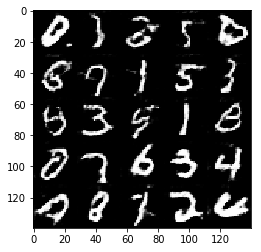

Epoch 2/2... Discriminator Loss: 0.4016... Generator Loss: 1.4310
Epoch 2/2... Discriminator Loss: 0.2755... Generator Loss: 1.8593
Epoch 2/2... Discriminator Loss: 1.8531... Generator Loss: 3.0653
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 0.5744
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 2.2618... Generator Loss: 0.1697
Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 1.7024
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 1.5685
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 2.4989


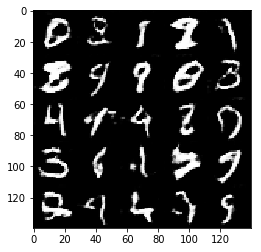

Epoch 2/2... Discriminator Loss: 1.5310... Generator Loss: 0.3888
Epoch 2/2... Discriminator Loss: 1.4855... Generator Loss: 0.3595
Epoch 2/2... Discriminator Loss: 1.9052... Generator Loss: 0.2998
Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 1.0916
Epoch 2/2... Discriminator Loss: 1.7127... Generator Loss: 3.4603
Epoch 2/2... Discriminator Loss: 0.5457... Generator Loss: 1.8968
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 2.4599
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 3.1534
Epoch 2/2... Discriminator Loss: 1.6490... Generator Loss: 0.3415


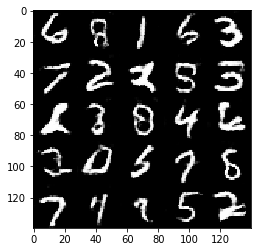

Epoch 2/2... Discriminator Loss: 1.6243... Generator Loss: 0.3171
Epoch 2/2... Discriminator Loss: 0.4494... Generator Loss: 2.5346
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4133
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 1.5787
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 2.1278
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.6780
Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 0.5739
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 1.2125
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 3.6771


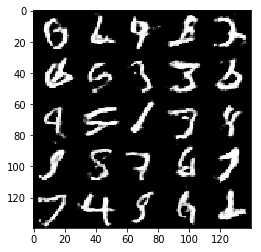

Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 0.6007
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.4200
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 2.8159
Epoch 2/2... Discriminator Loss: 0.8779... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 0.4486... Generator Loss: 1.6882
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 1.5567... Generator Loss: 0.4451
Epoch 2/2... Discriminator Loss: 0.5367... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 3.2591... Generator Loss: 6.5928


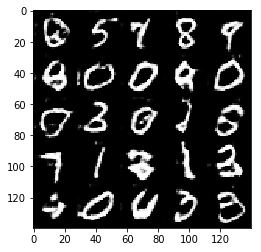

Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 2.2314
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 1.8123... Generator Loss: 4.8407
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 0.4734... Generator Loss: 1.2296
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 3.4893


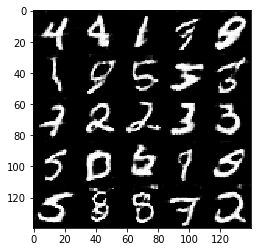

Epoch 2/2... Discriminator Loss: 0.4611... Generator Loss: 1.4509
Epoch 2/2... Discriminator Loss: 3.0075... Generator Loss: 0.1212
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 0.8937
Epoch 2/2... Discriminator Loss: 1.6162... Generator Loss: 0.3210
Epoch 2/2... Discriminator Loss: 0.4955... Generator Loss: 2.1733
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 0.2838... Generator Loss: 1.8185
Epoch 2/2... Discriminator Loss: 0.4479... Generator Loss: 1.4519
Epoch 2/2... Discriminator Loss: 0.5187... Generator Loss: 1.3257


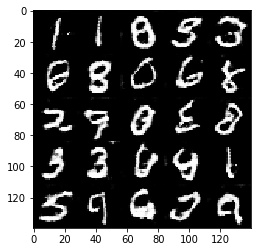

Epoch 2/2... Discriminator Loss: 2.2352... Generator Loss: 4.9436
Epoch 2/2... Discriminator Loss: 2.1477... Generator Loss: 5.0004
Epoch 2/2... Discriminator Loss: 0.6523... Generator Loss: 2.3520
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 0.5712... Generator Loss: 1.6021
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 4.4923
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 1.5186
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 1.3451


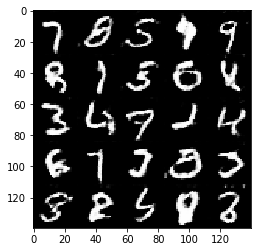

Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 2.2857
Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 1.1433
Epoch 2/2... Discriminator Loss: 0.2817... Generator Loss: 2.8660
Epoch 2/2... Discriminator Loss: 0.4374... Generator Loss: 2.5479
Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 2.4464
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 1.3099
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 2.4261... Generator Loss: 0.2350
Epoch 2/2... Discriminator Loss: 0.3830... Generator Loss: 1.5674


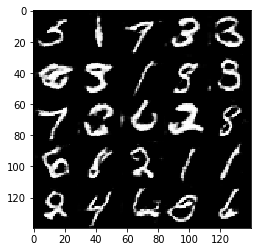

Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 4.2222
Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 0.5166... Generator Loss: 1.3900
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 1.6255
Epoch 2/2... Discriminator Loss: 2.5456... Generator Loss: 0.1431
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 0.7532


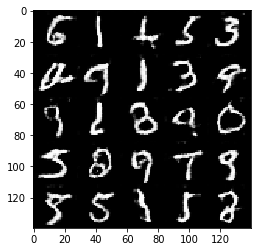

Epoch 2/2... Discriminator Loss: 0.2836... Generator Loss: 2.0720
Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 2.5985
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 1.0906
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 3.3921... Generator Loss: 6.2623
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.5830... Generator Loss: 0.3795
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 1.7076
Epoch 2/2... Discriminator Loss: 0.2960... Generator Loss: 1.9660


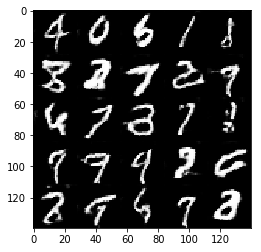

Epoch 2/2... Discriminator Loss: 2.9214... Generator Loss: 0.1043
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.3201
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 1.3986
Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 1.1735
Epoch 2/2... Discriminator Loss: 0.3756... Generator Loss: 1.5877
Epoch 2/2... Discriminator Loss: 0.3644... Generator Loss: 1.5243
Epoch 2/2... Discriminator Loss: 0.5666... Generator Loss: 1.2214
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.4961


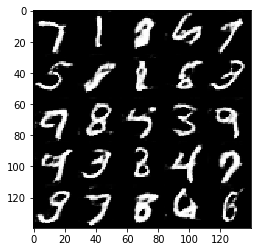

Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 1.0989
Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 2.0637
Epoch 2/2... Discriminator Loss: 2.5169... Generator Loss: 0.1590
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.1073
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 1.0223
Epoch 2/2... Discriminator Loss: 0.3479... Generator Loss: 1.7373
Epoch 2/2... Discriminator Loss: 0.4970... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 1.4928


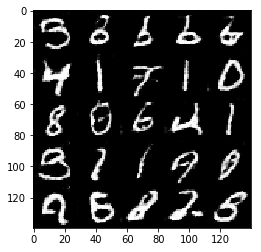

Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.5796
Epoch 2/2... Discriminator Loss: 0.3231... Generator Loss: 1.8752
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 3.0528
Epoch 2/2... Discriminator Loss: 2.4114... Generator Loss: 6.1738
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 0.3589... Generator Loss: 2.6667
Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 1.4528
Epoch 2/2... Discriminator Loss: 0.3439... Generator Loss: 1.7070
Epoch 2/2... Discriminator Loss: 1.6709... Generator Loss: 0.3344
Epoch 2/2... Discriminator Loss: 2.1150... Generator Loss: 5.0818


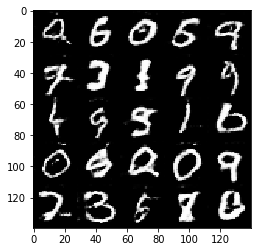

Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 0.9220
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 1.5868
Epoch 2/2... Discriminator Loss: 1.7192... Generator Loss: 0.3177
Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 1.5221
Epoch 2/2... Discriminator Loss: 0.2284... Generator Loss: 1.9971
Epoch 2/2... Discriminator Loss: 0.3420... Generator Loss: 1.8531
Epoch 2/2... Discriminator Loss: 0.4320... Generator Loss: 1.4286
Epoch 2/2... Discriminator Loss: 0.5755... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 3.5330


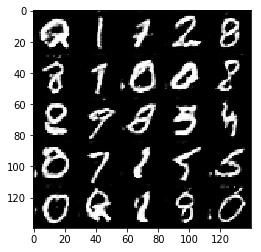

Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 0.4409... Generator Loss: 1.3637
Epoch 2/2... Discriminator Loss: 0.2831... Generator Loss: 1.8989
Epoch 2/2... Discriminator Loss: 2.9873... Generator Loss: 5.2335
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 2.3708
Epoch 2/2... Discriminator Loss: 1.7141... Generator Loss: 4.5374
Epoch 2/2... Discriminator Loss: 0.5213... Generator Loss: 1.3775
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 0.7578


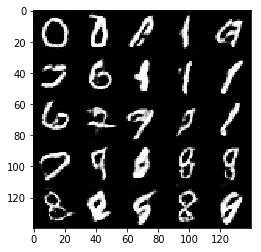

Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 0.5911... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 0.4704... Generator Loss: 1.3461
Epoch 2/2... Discriminator Loss: 0.9424... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 5.2458
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 2.2617
Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 1.1149
Epoch 2/2... Discriminator Loss: 0.6012... Generator Loss: 1.4728
Epoch 2/2... Discriminator Loss: 0.4847... Generator Loss: 2.0566
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 0.8406


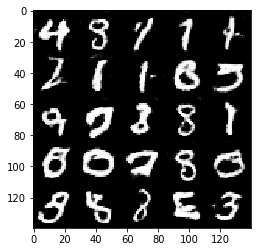

Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 1.5150
Epoch 2/2... Discriminator Loss: 2.1332... Generator Loss: 0.2705
Epoch 2/2... Discriminator Loss: 1.5863... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 1.4127
Epoch 2/2... Discriminator Loss: 0.2679... Generator Loss: 2.2206
Epoch 2/2... Discriminator Loss: 0.4395... Generator Loss: 1.4654
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 4.3424
Epoch 2/2... Discriminator Loss: 0.3397... Generator Loss: 2.3331
Epoch 2/2... Discriminator Loss: 0.3025... Generator Loss: 2.0543
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 1.5983


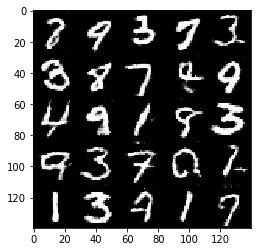

Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 4.3459
Epoch 2/2... Discriminator Loss: 0.5082... Generator Loss: 1.3551
Epoch 2/2... Discriminator Loss: 0.6004... Generator Loss: 1.8503
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 2.0355... Generator Loss: 0.2154


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2128... Generator Loss: 21.6529
Epoch 1/1... Discriminator Loss: 0.1878... Generator Loss: 16.1391
Epoch 1/1... Discriminator Loss: 0.0520... Generator Loss: 9.1026
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 8.4162... Generator Loss: 13.3630
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 2.8174... Generator Loss: 0.1384
Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 0.1939... Generator Loss: 2.2428


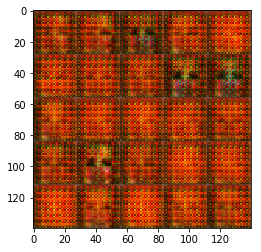

Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 4.7062
Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 1.8219
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 2.3839
Epoch 1/1... Discriminator Loss: 4.4507... Generator Loss: 9.9685
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 0.1473... Generator Loss: 2.3809
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.3424
Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 2.5280
Epoch 1/1... Discriminator Loss: 4.2114... Generator Loss: 8.5528
Epoch 1/1... Discriminator Loss: 1.9554... Generator Loss: 0.2617


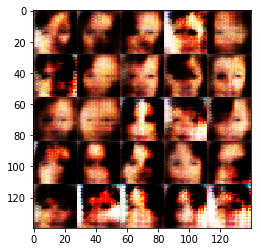

Epoch 1/1... Discriminator Loss: 0.1131... Generator Loss: 3.7797
Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 3.7920
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 4.6623
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 1.6668
Epoch 1/1... Discriminator Loss: 1.7947... Generator Loss: 5.6366
Epoch 1/1... Discriminator Loss: 2.3204... Generator Loss: 0.3369
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 2.1343... Generator Loss: 0.2036
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.6692


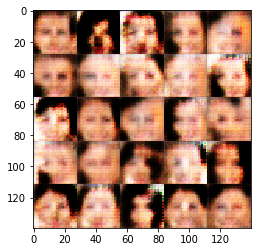

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.2883
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 3.3843
Epoch 1/1... Discriminator Loss: 1.9573... Generator Loss: 3.1189
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 2.6430
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 2.2170


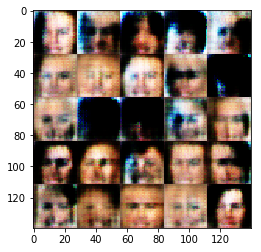

Epoch 1/1... Discriminator Loss: 2.2235... Generator Loss: 0.1701
Epoch 1/1... Discriminator Loss: 2.1435... Generator Loss: 0.1633
Epoch 1/1... Discriminator Loss: 0.3221... Generator Loss: 1.8143
Epoch 1/1... Discriminator Loss: 2.8701... Generator Loss: 5.9674
Epoch 1/1... Discriminator Loss: 0.1447... Generator Loss: 2.4451
Epoch 1/1... Discriminator Loss: 0.2952... Generator Loss: 2.7971
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.5366


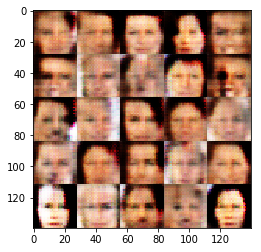

Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 2.5745
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 0.1796... Generator Loss: 2.2414
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 3.3270
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 3.7833


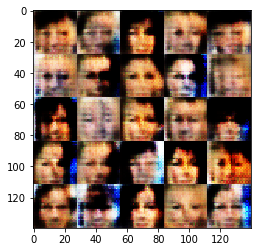

Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 4.1726
Epoch 1/1... Discriminator Loss: 0.1077... Generator Loss: 3.3996
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 5.2777
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 5.5858
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.8896... Generator Loss: 0.2491
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 2.0826
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.0683


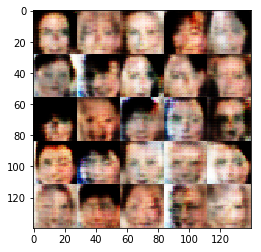

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 1.9779
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 0.2226... Generator Loss: 2.9588
Epoch 1/1... Discriminator Loss: 0.2150... Generator Loss: 1.8720
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 4.2590
Epoch 1/1... Discriminator Loss: 2.0527... Generator Loss: 3.5125
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 3.9013
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5032


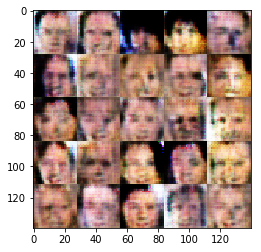

Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.8328
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 2.2869
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 3.4114
Epoch 1/1... Discriminator Loss: 4.4807... Generator Loss: 4.9664
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.9378


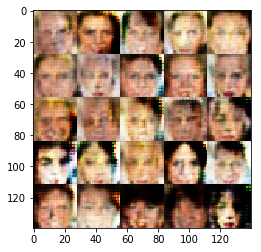

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 0.2255... Generator Loss: 1.9359
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.6696
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.2030... Generator Loss: 2.2881


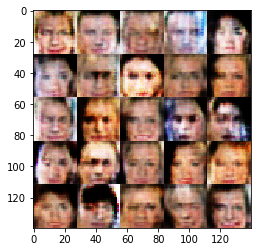

Epoch 1/1... Discriminator Loss: 0.2340... Generator Loss: 3.0009
Epoch 1/1... Discriminator Loss: 0.1534... Generator Loss: 2.5495
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 4.3009
Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 4.5194
Epoch 1/1... Discriminator Loss: 0.0656... Generator Loss: 3.2855
Epoch 1/1... Discriminator Loss: 2.8052... Generator Loss: 6.6366
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 3.8336... Generator Loss: 0.0282
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 3.1255


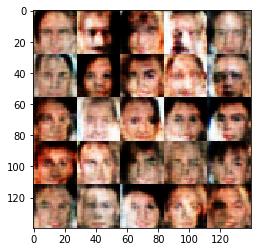

Epoch 1/1... Discriminator Loss: 3.1501... Generator Loss: 3.9626
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 2.1129
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 2.8490
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 3.0117
Epoch 1/1... Discriminator Loss: 2.2874... Generator Loss: 5.1924
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.3175
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 0.9269


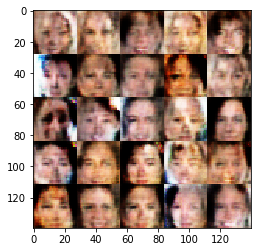

Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.7012... Generator Loss: 2.7598
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 1.8090... Generator Loss: 3.3815
Epoch 1/1... Discriminator Loss: 2.2691... Generator Loss: 3.4797
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 4.2482
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 1.9123
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 0.6768


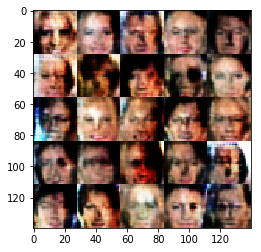

Epoch 1/1... Discriminator Loss: 1.6686... Generator Loss: 0.2828
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 3.6148
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 2.5523
Epoch 1/1... Discriminator Loss: 0.1105... Generator Loss: 2.7120
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 4.5656
Epoch 1/1... Discriminator Loss: 0.0288... Generator Loss: 4.2445
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 2.7200


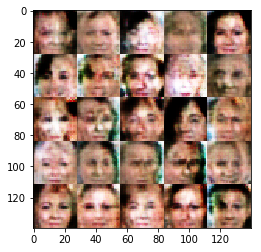

Epoch 1/1... Discriminator Loss: 4.3216... Generator Loss: 5.4621
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 3.3804
Epoch 1/1... Discriminator Loss: 0.0830... Generator Loss: 2.9108
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 1.6095
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.5515


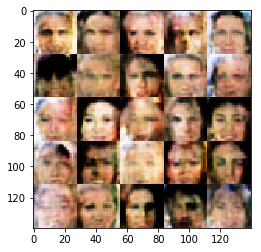

Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 2.6788
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.8992
Epoch 1/1... Discriminator Loss: 0.1436... Generator Loss: 2.4100
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 2.1540
Epoch 1/1... Discriminator Loss: 1.9255... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 2.1990


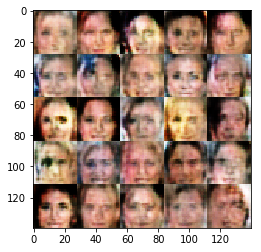

Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 4.1029
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 4.7195
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 2.0550
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.8814
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 1.7612
Epoch 1/1... Discriminator Loss: 3.4243... Generator Loss: 4.7044


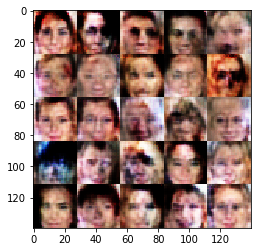

Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 2.6824
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 2.6717
Epoch 1/1... Discriminator Loss: 1.9776... Generator Loss: 3.4600
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 0.3045... Generator Loss: 1.9289
Epoch 1/1... Discriminator Loss: 0.1603... Generator Loss: 2.6423
Epoch 1/1... Discriminator Loss: 0.0330... Generator Loss: 5.1691
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.6518


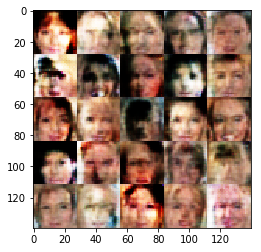

Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 2.1931
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 4.8242
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 2.1116... Generator Loss: 0.1933
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.3020
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 0.8156


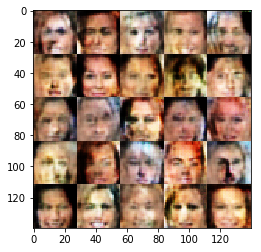

Epoch 1/1... Discriminator Loss: 0.2552... Generator Loss: 2.6471
Epoch 1/1... Discriminator Loss: 2.8985... Generator Loss: 4.7990
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 2.8226
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 3.4582
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 3.2601
Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 2.0245
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 2.8543
Epoch 1/1... Discriminator Loss: 0.1971... Generator Loss: 2.4309
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 4.4298
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 2.0864


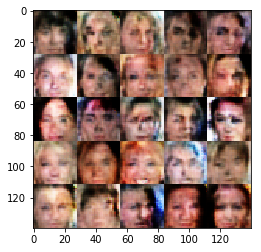

Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 2.4929
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 3.5273... Generator Loss: 4.9711
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 2.5991
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 3.0659
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 2.7801
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 0.6845


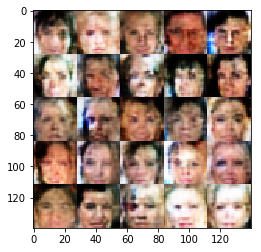

Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 2.9741
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 2.2986
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 2.6829
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 5.0269
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 4.7332


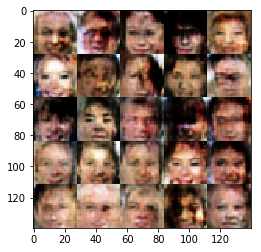

Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 3.0434
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 5.9263
Epoch 1/1... Discriminator Loss: 3.8165... Generator Loss: 5.6465
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 2.3498
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.4990
Epoch 1/1... Discriminator Loss: 0.1156... Generator Loss: 2.6089
Epoch 1/1... Discriminator Loss: 0.0973... Generator Loss: 3.2628
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 3.7963
Epoch 1/1... Discriminator Loss: 0.2435... Generator Loss: 1.9630
Epoch 1/1... Discriminator Loss: 2.1553... Generator Loss: 3.7652


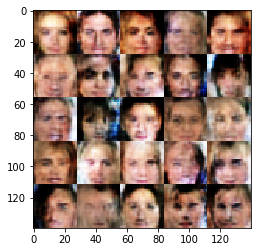

Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 2.3804
Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 2.9960
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 4.3405
Epoch 1/1... Discriminator Loss: 0.2328... Generator Loss: 1.8465
Epoch 1/1... Discriminator Loss: 0.0286... Generator Loss: 6.1059
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 2.0592... Generator Loss: 0.2008


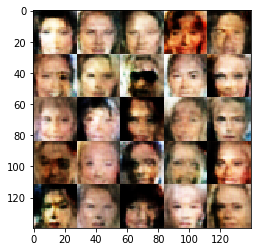

Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 4.1579
Epoch 1/1... Discriminator Loss: 0.0487... Generator Loss: 3.8362
Epoch 1/1... Discriminator Loss: 5.0991... Generator Loss: 5.5491
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 0.1422... Generator Loss: 2.4696
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 3.3337
Epoch 1/1... Discriminator Loss: 1.6639... Generator Loss: 3.4162
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.2419... Generator Loss: 1.9288


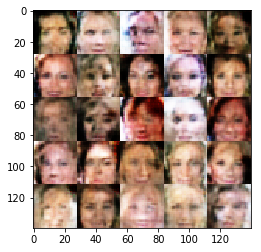

Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 2.3573
Epoch 1/1... Discriminator Loss: 2.7817... Generator Loss: 4.8268
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 1.7428
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.4482
Epoch 1/1... Discriminator Loss: 0.1913... Generator Loss: 2.3782
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 1.7899
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 2.2562
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 1.4569


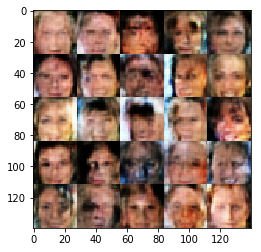

Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 2.3076
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 3.7575
Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 4.4065
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.9550
Epoch 1/1... Discriminator Loss: 0.2857... Generator Loss: 1.9819
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 3.8802
Epoch 1/1... Discriminator Loss: 0.3720... Generator Loss: 5.3756


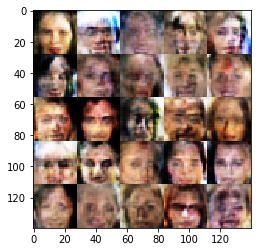

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 3.4216
Epoch 1/1... Discriminator Loss: 2.9566... Generator Loss: 4.5658
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 3.8540
Epoch 1/1... Discriminator Loss: 1.9058... Generator Loss: 1.6160
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 2.4269... Generator Loss: 0.1679
Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 2.9577
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 2.8875
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 2.7830


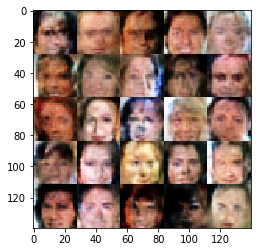

Epoch 1/1... Discriminator Loss: 0.0608... Generator Loss: 3.7394
Epoch 1/1... Discriminator Loss: 2.0034... Generator Loss: 0.2082
Epoch 1/1... Discriminator Loss: 0.2918... Generator Loss: 2.7292
Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 3.2331
Epoch 1/1... Discriminator Loss: 2.0362... Generator Loss: 0.2021
Epoch 1/1... Discriminator Loss: 0.0939... Generator Loss: 3.8975
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 4.7902
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.0020


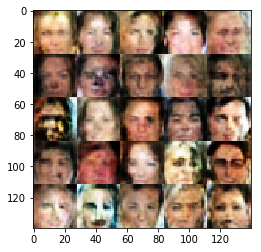

Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 1.8475
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.2925
Epoch 1/1... Discriminator Loss: 0.2290... Generator Loss: 1.9958
Epoch 1/1... Discriminator Loss: 0.4288... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 3.2234
Epoch 1/1... Discriminator Loss: 0.1420... Generator Loss: 2.7422
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 0.0498... Generator Loss: 3.8082
Epoch 1/1... Discriminator Loss: 1.9883... Generator Loss: 0.2803
Epoch 1/1... Discriminator Loss: 0.2537... Generator Loss: 1.7947


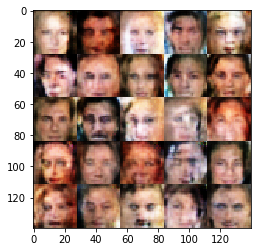

Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 4.3347
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 4.4880
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 0.2117... Generator Loss: 2.1707
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.7888
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 0.2055... Generator Loss: 2.1155
Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 4.3810
Epoch 1/1... Discriminator Loss: 0.0739... Generator Loss: 4.1794


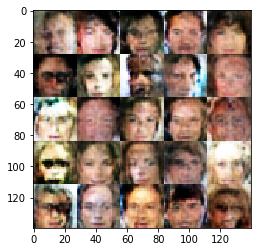

Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 4.2229
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 3.6493
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.5092
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 3.2677
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 3.1371
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 1.9523
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 2.7894


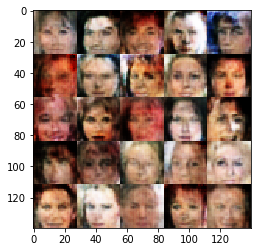

Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 2.6474
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 0.1299... Generator Loss: 3.9768
Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 4.1288
Epoch 1/1... Discriminator Loss: 2.3010... Generator Loss: 4.6066
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.5871
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 2.8230
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 0.0645... Generator Loss: 3.2947
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 2.8451


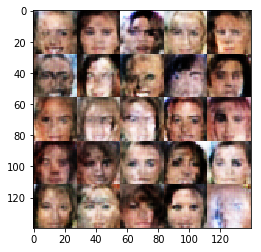

Epoch 1/1... Discriminator Loss: 0.1323... Generator Loss: 2.8140
Epoch 1/1... Discriminator Loss: 2.4017... Generator Loss: 3.2937
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 2.3811
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 3.0248
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.3140... Generator Loss: 3.1238
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 2.7872
Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 4.5571
Epoch 1/1... Discriminator Loss: 0.1197... Generator Loss: 2.7119
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.6500


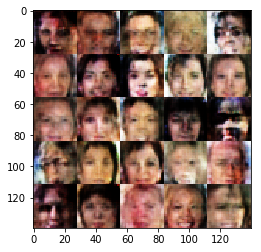

Epoch 1/1... Discriminator Loss: 0.1184... Generator Loss: 2.5738
Epoch 1/1... Discriminator Loss: 0.1291... Generator Loss: 2.9376
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 2.9482
Epoch 1/1... Discriminator Loss: 0.3025... Generator Loss: 3.3305
Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 3.1152
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 3.2926
Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 3.1279
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 5.1110
Epoch 1/1... Discriminator Loss: 0.1446... Generator Loss: 3.3261
Epoch 1/1... Discriminator Loss: 1.6499... Generator Loss: 4.4125


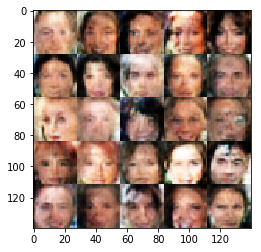

Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 3.0052
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 2.7051
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 3.2740
Epoch 1/1... Discriminator Loss: 0.2385... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 4.9034
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 2.8577
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 3.6439


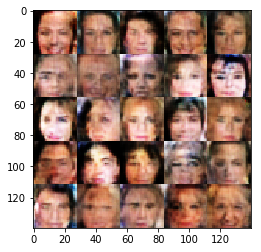

Epoch 1/1... Discriminator Loss: 0.2127... Generator Loss: 2.1342
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.3112
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 5.2217
Epoch 1/1... Discriminator Loss: 4.6974... Generator Loss: 0.0169
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.7719... Generator Loss: 0.2626
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 1.6765
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 0.2120... Generator Loss: 3.2594
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.4681


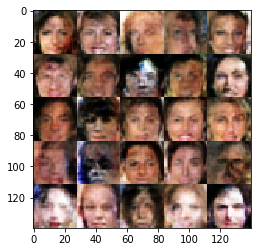

Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 1.5360
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 2.1602
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 2.2357
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 4.3492
Epoch 1/1... Discriminator Loss: 0.0798... Generator Loss: 3.6641
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 2.9009
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 1.7108
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 1.7099


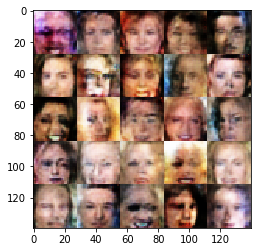

Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 4.0861
Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 3.3671
Epoch 1/1... Discriminator Loss: 0.0914... Generator Loss: 4.1194
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.0484... Generator Loss: 4.2293
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.7367
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 2.9906
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 2.2700
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 2.8379
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 2.6321


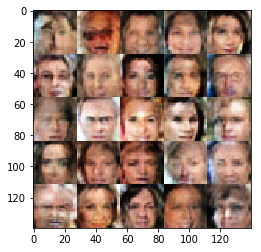

Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.2497... Generator Loss: 1.7482
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 3.9940
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.7529
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 3.8717
Epoch 1/1... Discriminator Loss: 2.4556... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 1.3536
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.3976
Epoch 1/1... Discriminator Loss: 0.2153... Generator Loss: 4.3263


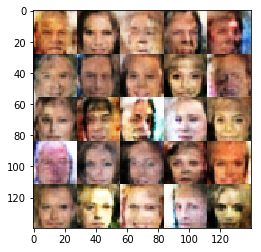

Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 2.4293
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.9566
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 3.5197
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 4.3867
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 3.7203
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 3.1671
Epoch 1/1... Discriminator Loss: 0.1718... Generator Loss: 3.2448


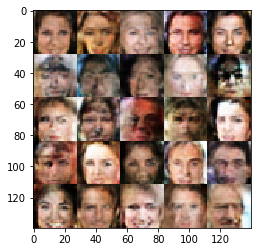

Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 4.4775
Epoch 1/1... Discriminator Loss: 0.0691... Generator Loss: 5.3843
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 2.9268
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 3.4058
Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 7.1881
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 4.7351
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 6.6599
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 0.2227... Generator Loss: 2.6614
Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 4.9020


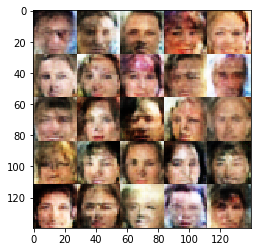

Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 2.1619
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 3.8565
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.8462... Generator Loss: 0.2569
Epoch 1/1... Discriminator Loss: 0.1278... Generator Loss: 2.6210
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 3.1511
Epoch 1/1... Discriminator Loss: 0.1474... Generator Loss: 2.7302
Epoch 1/1... Discriminator Loss: 0.0826... Generator Loss: 3.7834


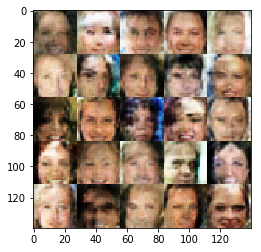

Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 2.5783
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.3032
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 2.2723
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 0.2104... Generator Loss: 2.0134
Epoch 1/1... Discriminator Loss: 0.2304... Generator Loss: 2.2960
Epoch 1/1... Discriminator Loss: 0.3195... Generator Loss: 2.8243
Epoch 1/1... Discriminator Loss: 0.2039... Generator Loss: 2.1304
Epoch 1/1... Discriminator Loss: 0.3235... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 0.1327... Generator Loss: 2.6077


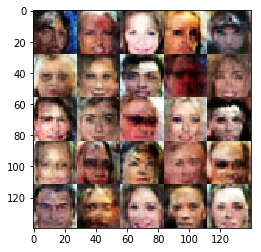

Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 2.0899
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 0.2133... Generator Loss: 2.2102
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 2.5276
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.1029
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 1.8189
Epoch 1/1... Discriminator Loss: 2.2826... Generator Loss: 6.0028
Epoch 1/1... Discriminator Loss: 0.1482... Generator Loss: 2.6863


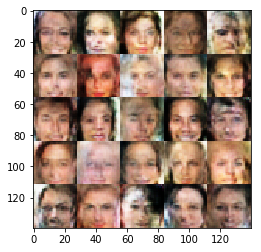

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 4.3269
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 4.0225
Epoch 1/1... Discriminator Loss: 0.1906... Generator Loss: 2.6955
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 2.4457
Epoch 1/1... Discriminator Loss: 0.2687... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 2.9251
Epoch 1/1... Discriminator Loss: 2.3580... Generator Loss: 4.5495
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 2.6713
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 2.2839
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.3942


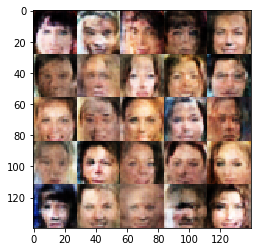

Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 3.0844
Epoch 1/1... Discriminator Loss: 0.1282... Generator Loss: 2.7852
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 2.4362
Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 3.8050
Epoch 1/1... Discriminator Loss: 0.3209... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 6.1594
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 3.8008
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.3434


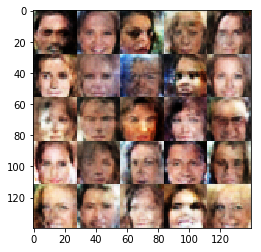

Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 3.1635
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 4.0131
Epoch 1/1... Discriminator Loss: 2.5795... Generator Loss: 0.1313
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 3.0484
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 3.1066
Epoch 1/1... Discriminator Loss: 0.1971... Generator Loss: 2.6055
Epoch 1/1... Discriminator Loss: 2.8162... Generator Loss: 0.0916
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 0.1062... Generator Loss: 3.0589


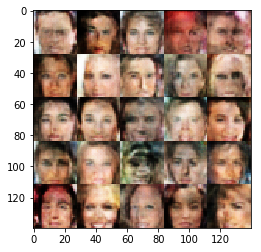

Epoch 1/1... Discriminator Loss: 0.2153... Generator Loss: 1.9767
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 0.1095... Generator Loss: 2.6614
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 3.5187
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 2.8339
Epoch 1/1... Discriminator Loss: 0.0832... Generator Loss: 3.0653
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.5557


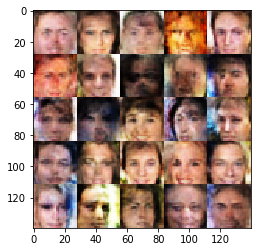

Epoch 1/1... Discriminator Loss: 0.2336... Generator Loss: 1.9966
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 2.2706
Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 4.1994
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 5.5405
Epoch 1/1... Discriminator Loss: 0.2152... Generator Loss: 3.3955
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 3.5605
Epoch 1/1... Discriminator Loss: 0.1628... Generator Loss: 2.3402


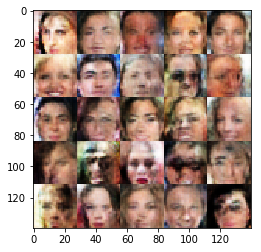

Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 1.3850
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 4.6339
Epoch 1/1... Discriminator Loss: 0.0961... Generator Loss: 3.0970
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 3.9682
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 3.5083
Epoch 1/1... Discriminator Loss: 0.1066... Generator Loss: 2.6934
Epoch 1/1... Discriminator Loss: 2.7256... Generator Loss: 0.1358
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 3.3976
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 3.2070
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 1.0444


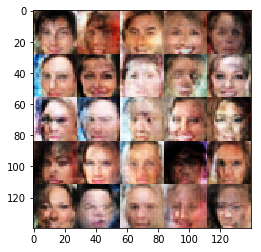

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 4.0967
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 3.5025
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.6516
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 3.4013
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 3.0524
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 2.9019
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 4.8596
Epoch 1/1... Discriminator Loss: 1.7502... Generator Loss: 4.3440
Epoch 1/1... Discriminator Loss: 2.2163... Generator Loss: 0.2776
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 3.7689


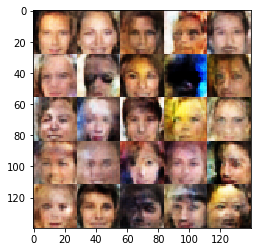

Epoch 1/1... Discriminator Loss: 0.2059... Generator Loss: 2.1690
Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 1.8299
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 3.4371
Epoch 1/1... Discriminator Loss: 0.0309... Generator Loss: 5.1181
Epoch 1/1... Discriminator Loss: 0.1072... Generator Loss: 3.2715
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 1.4149
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.7462
Epoch 1/1... Discriminator Loss: 1.8325... Generator Loss: 4.9871
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 3.8087


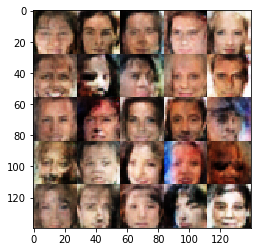

Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 4.9179
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 4.0078
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 2.1233
Epoch 1/1... Discriminator Loss: 0.1044... Generator Loss: 3.1033
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 4.1183
Epoch 1/1... Discriminator Loss: 0.1642... Generator Loss: 2.4826
Epoch 1/1... Discriminator Loss: 0.0644... Generator Loss: 4.7904
Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 3.3618


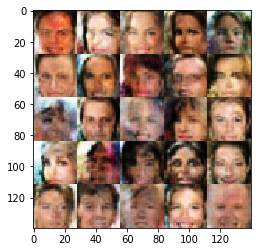

Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 5.4439
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.2078... Generator Loss: 2.4234
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 3.3502
Epoch 1/1... Discriminator Loss: 0.3023... Generator Loss: 2.4667
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 0.1337... Generator Loss: 2.7099
Epoch 1/1... Discriminator Loss: 0.2390... Generator Loss: 2.7906
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 2.9835
Epoch 1/1... Discriminator Loss: 0.0884... Generator Loss: 3.5310


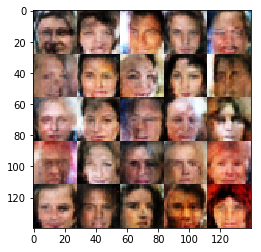

Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 4.0109
Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 5.2596
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.7035... Generator Loss: 5.4262
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 3.6652
Epoch 1/1... Discriminator Loss: 0.1357... Generator Loss: 2.7135
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 3.3206
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 3.5520
Epoch 1/1... Discriminator Loss: 0.1197... Generator Loss: 2.5939
Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 6.4402


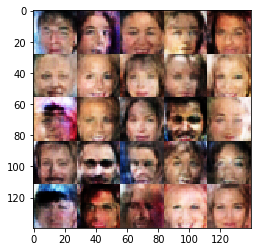

Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 0.2891... Generator Loss: 1.8874
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 5.2854
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 0.1169... Generator Loss: 2.9571
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 2.8292


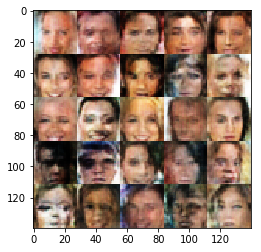

Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 5.2911
Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 5.0037
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 3.5611
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 4.8328
Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 2.8323
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 3.2972
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 4.5663


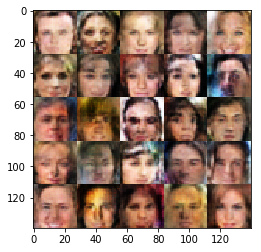

Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 2.4237
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 3.9259
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 3.1473
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 2.8030
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 3.8665
Epoch 1/1... Discriminator Loss: 0.1957... Generator Loss: 2.3085
Epoch 1/1... Discriminator Loss: 0.1342... Generator Loss: 3.2720
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 2.3977
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 5.1015
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 3.8911


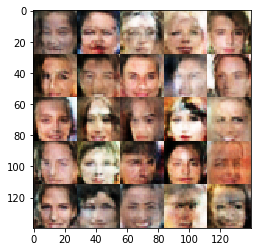

Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 4.2352
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 0.2195... Generator Loss: 3.5260
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 3.9639
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 4.4662
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 4.3739


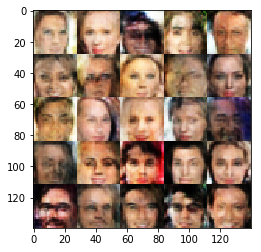

Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 1.5491
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 3.0913
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 4.1168
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 4.0807
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.1138... Generator Loss: 2.8295
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 4.4752


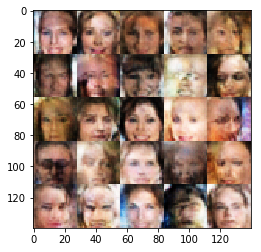

Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 2.7054
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 2.9684
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 3.3905
Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 4.4197
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 2.8135
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 4.6795
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 2.8799
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 5.6855


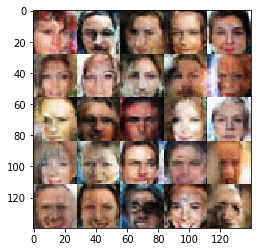

Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 4.0921
Epoch 1/1... Discriminator Loss: 0.0896... Generator Loss: 4.5030
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 2.8929
Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 1.4707
Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 2.9900
Epoch 1/1... Discriminator Loss: 0.1188... Generator Loss: 3.2069
Epoch 1/1... Discriminator Loss: 0.1117... Generator Loss: 4.4458
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 1.3950
Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 2.4852
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 0.8210


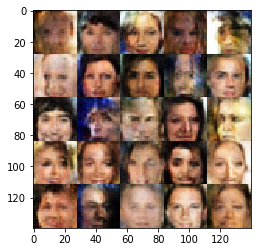

Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 2.2645
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 2.2915
Epoch 1/1... Discriminator Loss: 0.1148... Generator Loss: 3.8602


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.